# Optimization - HW 2

Implement and test the conjugate-gradient method of optimization for multi-variable unconstrained optimization problems,  of dimensions at least 2 and 10. You may choose the problems but give them nontrivial dependencies among the variables. (For example, Rosenbrock’s function for dimension 2.) 

Parameters to vary include: 
* number of CG iterates before restart; stopping criterion 
* others optional (eg control parameters or stopping criteria for the line minimization search). 

For each value of the parameters report:
* average error of the output argument vector
* function value produced by the algorithm, and also 
* total number of CG iterations (not sweeps) as a measure of computational cost, along with statistical error bars on those quantities. 

Probability distribution to use in producing a single average error measurement includes a distribution (eg a broad Gaussian) over starting points; just say what you chose.

#### Some preliminaries: let's use Rosenbrock function as a performance test for our conjugate-gradient method

From wikipedia, the function is defined by

$f(x, y) = (x-a)^2 + b(x^2-y)^2$

The function has a global minimum at $(x, y) = (a, a^2)$. For simplicity, we'll set the parameters $a = 1$ and $b = 100$.

In [1]:
%matplotlib inline

In [2]:
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def rosenbrock(p, a=1., b=100.):
    x, y = p
    return (x - a)**2 + b*(x*x - y)**2

Let's take a look at the Rosenbrock function for $a=1, b=100$ 

In [4]:
s = 0.05
x = np.arange(-2, 2.+s, s)
y = np.arange(-2, 3.+s, s)
X, Y = np.meshgrid(x, y)

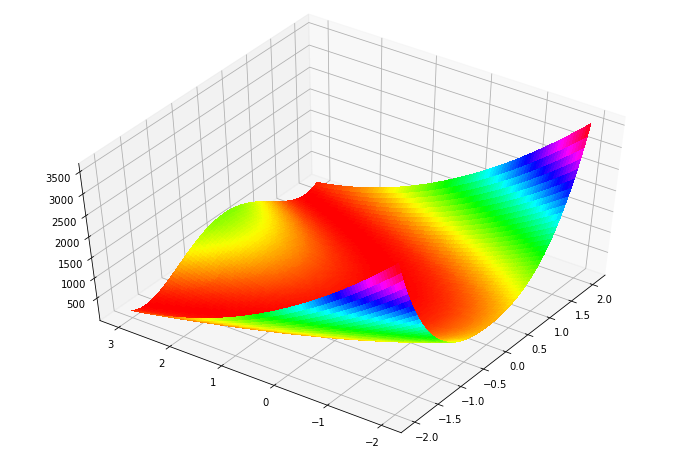

In [5]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')

ax.view_init(elev=50, azim=-145)
ax.plot_surface(X, Y, rosenbrock((X, Y)), rstride=1, cstride=1,
                cmap=cm.hsv, linewidth=0, antialiased=False)

### Gradient of rosenbrock function

$$
\begin{align}
    \nabla f(x, y) &= \begin{bmatrix}
        \frac{\partial f(x, y)}{\partial x} \\
        \frac{\partial f(x, y)}{\partial y}
        \end{bmatrix} \\
     \nabla f(x, y) &= \begin{bmatrix}
         2(x-a) + 4bx(x^2-y) \\
         2b(y-x^2)
         \end{bmatrix}
\end{align}
$$

### Hessian of rosenbrock
$$
\begin{align}
{\nabla}^2 f(x, y) &= \begin{bmatrix}
    \frac{{\partial}^2 f(x, y)}{\partial x^2} &  \frac{{\partial}^2 f(x, y)}{\partial y \partial x} \\
    \frac{{\partial}^2 f(x, y)}{\partial y \partial x} &  \frac{{\partial}^2 f(x, y)}{\partial y^2}
    \end{bmatrix} \\
{\nabla}^2 f(x, y) &= \begin{bmatrix}
    2(6bx^2 - 2by + 1) & -4bx \\
    -4bx               & 2b
    \end{bmatrix}
\end{align}
$$

In [6]:
def rosenbrock_grad(p, a=1., b=100.):
    x, y = p
    gx = 2*(x - a) + 4*b*x*(x*x - y)
    gy = 2*b*(y - x*x)
    return np.array([gx, gy])

In [7]:
def rosenbrock_grad2(p, a=1., b=100.):
    x, y = p
    gxx = 2*(6*b*x*x - 2*b*y + 1)
    gxy = -4*b*x
    gyy = 2*b
    return np.array([[gxx, gxy], [gxy, gyy]])

In [8]:
# Quick test of the conjugate gradient for 2-D Rosenbrock
eps = 1e-14
x = (-5, 5)
k = 0
r = -rosenbrock_grad(x)
d = r
delta_new = np.dot(r.T, r)
delta_0 = delta_new
for i in range(500):
    delta_d = np.dot(d.T, d)
    for j in range(500):
        alpha = -np.dot(rosenbrock_grad(x).T, d) / np.dot(np.dot(d.T, rosenbrock_grad2(x)), d)
        x = x + alpha*d
        if alpha*alpha*delta_d <= eps*eps:
            break
    r = -rosenbrock_grad(x)
    delta_old = delta_new
    delta_new = np.dot(r.T, r)
    beta = delta_new / delta_old
    d = r + beta*d
    k = k + 1
    if k == 10 or np.dot(r.T, d) <= 0:  # restart every 10th iteration
        d = r
        k = 0
    if delta_new <= eps*eps*delta_0:
        break
        
print(x)

[ 1.  1.]


### Here we will generalize the rosenbrock function and the gradients/hessian for n dimensions. 

In [9]:
def nrosenbrock(x, a=1., b=100.):
    return sum(b*(x[1:] - x[:-1]**2.)**2. + (a - x[:-1])**2.)

def nrosenbrock_grad(x, a= 1., b=100.):
    x1 = x[1:-1]
    x1_m1 = x[:-2]
    x1_p1 = x[2:]
    D = np.zeros_like(x, dtype=np.float64)
    D[1:-1] = 2*b*(x1 - x1_m1**2.) - 4*b*(x1_p1 - x1**2)*x1 - 2*(a - x1)
    D[0] = -4*b*x[0]*(x[1] - x[0]**2) - 2*(a - x[0])
    D[-1] = 2*b*(x[-1] - x[-2]**2.)
    return D

def nrosenbrock_hessian(x, a=1., b=100.):
    v = np.asarray(x, dtype=np.float64)
    H = np.diag(-4*b*v[:-1], 1) - np.diag(2*b*v[:-1], -1)
    diag = np.zeros_like(v)
    diag[0] = 1200*v[0]**2 - 400*v[1] + 2
    diag[-1] = 200
    diag[1:-1] = 202 + 1200*v[1:-1]**2 - 400*v[2:]
    H = H + np.diag(diag)
    return H

### We will use conjugate gradient method and newton's method for line search

In [10]:
def cg_newton(x0, f_grad, f_hessian, eps=1e-10, niter=500, restart=10):
    total_restarts = 0
    total_cg = 0
    x = x0
    k = 0
    d = r = -f_grad(x)
    delta_0 = delta_new = np.dot(r.T, r)
    for i in range(niter):
        delta_d = np.dot(d.T, d)
        for j in range(niter):
            alpha = -np.dot(f_grad(x).T, d) / np.dot(np.dot(d.T, f_hessian(x)), d)
            x = x + alpha*d
            if alpha*alpha*delta_d <= eps*eps:
                break
        r = -f_grad(x)
        delta_old = delta_new
        delta_new = np.dot(r.T, r)
        beta = delta_new / delta_old
        d = r + beta*d
        k += 1
        if k == restart or np.dot(r.T, d) <= 0:  # restart every 10th iteration
            total_restarts += 1
            d = r
            k = 0
        total_cg += 1
        if delta_new <= eps*eps*delta_0:
            total_cg = i
            break
    return np.append(x, [total_cg, total_restarts])

### The design of the experiment is to sample from Normal distribution and vary the number of max iterations

In [11]:
np.random.seed(13)  # Set random seed for reproducibility
mu, sigma = 1., 3.

n = 5  # number of samples/simulations
nparams = 2

x0_2d = np.random.normal(mu, sigma, (n, 2, nparams))   # 2-D initial starting point
x0_10d = np.random.normal(mu, sigma, (n, 10, nparams)) # 10-D initial starting point

In [12]:
np.set_printoptions(precision=20)
pd.options.display.precision = 20

niter20_restart5_2d = []
niter200_restart5_2d = []

niter20_restart5_10d = []
niter200_restart5_10d = []


for i in range(n):
    niter20_restart5_2d.append(
        cg_newton(x0_2d[i,:,0], nrosenbrock_grad, nrosenbrock_hessian, niter=20, restart=5))
    niter200_restart5_2d.append(
        cg_newton(x0_2d[i,:,1], nrosenbrock_grad, nrosenbrock_hessian, niter=200, restart=5))
    
    niter20_restart5_10d.append(
        cg_newton(x0_10d[i,:,0], nrosenbrock_grad, nrosenbrock_hessian, niter=20, restart=5))
    niter200_restart5_10d.append(
        cg_newton(x0_10d[i,:,1], nrosenbrock_grad, nrosenbrock_hessian, niter=200, restart=5))

In [13]:
# We will convert all numpy arrays to a pandas dataframe so we can easilty compute statistics
# and print in latex form for the writeup

columns2d = ['x1', 'x2', 'total_cg_iters', 'total_restarts']
columns10d = ['x1', 'x2', 'x3', 'x4', 'x5',
              'x6', 'x7', 'x8', 'x9', 'x10',
              'total_cg_iters', 'total_restarts']

niter20_restart5_2d = pd.DataFrame(np.array(niter20_restart5_2d))
niter20_restart5_2d.columns = columns2d

niter200_restart5_2d = pd.DataFrame(np.array(niter200_restart5_2d))
niter200_restart5_2d.columns = columns2d

niter20_restart5_10d = pd.DataFrame(np.array(niter20_restart5_10d))
niter20_restart5_10d.columns = columns10d

niter200_restart5_10d = pd.DataFrame(np.array(niter200_restart5_10d))
niter200_restart5_10d.columns = columns10d

In [14]:
niter20_restart5_2d

,x1,x2,total_cg_iters,total_restarts
0,0.74283539129386377819,0.55607669912270873969,20.0,4.0
1,2.14882691591589347624,4.63062908223230529359,20.0,4.0
2,0.85485250986842287180,0.72751165387310512411,20.0,4.0
3,1.78547862523670919366,3.19966001366487295954,20.0,4.0
4,1.48522861932071092994,2.21516907478576596802,20.0,4.0


In [15]:
print(niter20_restart5_2d.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &                      x1 &                      x2 &  total\_cg\_iters &  total\_restarts \\
\midrule
0 &  0.74283539129386377819 &  0.55607669912270873969 &            20.0 &             4.0 \\
1 &  2.14882691591589347624 &  4.63062908223230529359 &            20.0 &             4.0 \\
2 &  0.85485250986842287180 &  0.72751165387310512411 &            20.0 &             4.0 \\
3 &  1.78547862523670919366 &  3.19966001366487295954 &            20.0 &             4.0 \\
4 &  1.48522861932071092994 &  2.21516907478576596802 &            20.0 &             4.0 \\
\bottomrule
\end{tabular}



In [16]:
niter20_restart5_2d.describe()

,x1,x2,total_cg_iters,total_restarts
count,5.00000000000000000000,5.00000000000000000000,5.0,5.0
mean,1.40344441232711991674,2.26580930473575170581,20.0,4.0
std,0.60116371046434968761,1.71439197711911561761,0.0,0.0
min,0.74283539129386377819,0.55607669912270873969,20.0,4.0
25%,0.85485250986842287180,0.72751165387310512411,20.0,4.0
50%,1.48522861932071092994,2.21516907478576596802,20.0,4.0
75%,1.78547862523670919366,3.19966001366487295954,20.0,4.0
max,2.14882691591589347624,4.63062908223230529359,20.0,4.0


In [17]:
niter200_restart5_2d

,x1,x2,total_cg_iters,total_restarts
0,1.00000049695107273706,1.00000099613170134738,45.0,9.0
1,1.00000033754590567092,1.00000067648149704169,50.0,10.0
2,0.99999937544333583617,0.99999874844393632500,45.0,9.0
3,0.99999997375211158168,0.99999994732085217830,41.0,8.0
4,1.00000836441840079694,1.00001679016861744209,31.0,6.0


In [18]:
print(niter200_restart5_2d.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &                      x1 &                      x2 &  total\_cg\_iters &  total\_restarts \\
\midrule
0 &  1.00000049695107273706 &  1.00000099613170134738 &            45.0 &             9.0 \\
1 &  1.00000033754590567092 &  1.00000067648149704169 &            50.0 &            10.0 \\
2 &  0.99999937544333583617 &  0.99999874844393632500 &            45.0 &             9.0 \\
3 &  0.99999997375211158168 &  0.99999994732085217830 &            41.0 &             8.0 \\
4 &  1.00000836441840079694 &  1.00001679016861744209 &            31.0 &             6.0 \\
\bottomrule
\end{tabular}



In [19]:
niter200_restart5_2d.describe()

,x1,x2,total_cg_iters,total_restarts
count,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000
mean,1.00000170962216516912,1.00000343170932071146,42.39999999999999857891,8.40000000000000035527
std,0.00000374503381254004,0.00000751740798319008,7.12741187248218466266,1.51657508881031000136
min,0.99999937544333583617,0.99999874844393632500,31.00000000000000000000,6.00000000000000000000
25%,0.99999997375211158168,0.99999994732085217830,41.00000000000000000000,8.00000000000000000000
50%,1.00000033754590567092,1.00000067648149704169,45.00000000000000000000,9.00000000000000000000
75%,1.00000049695107273706,1.00000099613170134738,45.00000000000000000000,9.00000000000000000000
max,1.00000836441840079694,1.00001679016861744209,50.00000000000000000000,10.00000000000000000000


In [20]:
niter20_restart5_10d

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,total_cg_iters,total_restarts
0,-0.94219885945736370214,0.90828582527305234962,0.81599044869171966088,0.67378859329122420263,0.45048860224938003238,0.20609519222377153946,0.04178590087294471039,0.04065438917649590034,0.00528726405673964062,0.00445424083671278580,20.0,4.0
1,0.29044258337665534997,0.07186925914368155754,-0.10985600880970518289,0.27713550205372661228,0.54191747699541459315,0.73499686361849403404,0.85810082698032674742,0.94888885947143608579,0.98698464645559225161,1.00059960865743668990,20.0,4.0
2,0.81167818207712072454,0.63725008586832676549,0.37790146602101354345,0.12332850298478541251,0.02947269183711559784,0.01105812003302780212,0.01048477016865899739,0.01043112635835508756,0.01014195612652997285,0.00017851655861885840,20.0,4.0
3,0.69540174840437374293,0.47272757263157960672,0.17380321328711020867,0.02902065864927411837,0.01076978855088386693,0.01022563159175566595,0.01045577542026477832,0.00977811711503599745,0.00971281644359103281,0.00030625693020054976,20.0,4.0
4,0.79843284270192493857,0.60829384320480195392,0.32130378546406668239,0.11481411836736202248,0.02244446000121021190,0.01223609374757178569,0.01115355706253752348,0.01116226331561907641,0.01037866795201842010,0.00005939269420386666,20.0,4.0


In [21]:
print(niter20_restart5_10d.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} &                      x1 &                      x2 &                      x3 &                      x4 &                      x5 &                      x6 &                      x7 &                      x8 &                      x9 &                     x10 &  total\_cg\_iters &  total\_restarts \\
\midrule
0 & -0.94219885945736370214 &  0.90828582527305234962 &  0.81599044869171966088 &  0.67378859329122420263 &  0.45048860224938003238 &  0.20609519222377153946 &  0.04178590087294471039 &  0.04065438917649590034 &  0.00528726405673964062 &  0.00445424083671278580 &            20.0 &             4.0 \\
1 &  0.29044258337665534997 &  0.07186925914368155754 & -0.10985600880970518289 &  0.27713550205372661228 &  0.54191747699541459315 &  0.73499686361849403404 &  0.85810082698032674742 &  0.94888885947143608579 &  0.98698464645559225161 &  1.00059960865743668990 &            20.0 &             4.0 \\
2 &  0.81167818207712072454 &  0.63725008586

In [22]:
niter20_restart5_10d.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,total_cg_iters,total_restarts
count,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.0,5.0
mean,0.33075129942054221077,0.53968531722428847441,0.31582858093084098527,0.24361747506927447504,0.21101860392680085732,0.19492238024292415921,0.18639616610094655869,0.20418295108738840349,0.20450107020689425874,0.20111960313543453260,20.0,4.0
std,0.74246440014123449291,0.30554359435709438353,0.33742535837095261053,0.25655515206563067609,0.26242077771581739931,0.31348784415797348313,0.37573564263012826370,0.41650884609702143457,0.43742660062782195984,0.44692674804408233369,0.0,0.0
min,-0.94219885945736370214,0.07186925914368155754,-0.10985600880970518289,0.02902065864927411837,0.01076978855088386693,0.01022563159175566595,0.01045577542026477832,0.00977811711503599745,0.00528726405673964062,0.00005939269420386666,20.0,4.0
25%,0.29044258337665534997,0.47272757263157960672,0.17380321328711020867,0.11481411836736202248,0.02244446000121021190,0.01105812003302780212,0.01048477016865899739,0.01043112635835508756,0.00971281644359103281,0.00017851655861885840,20.0,4.0
50%,0.69540174840437374293,0.60829384320480195392,0.32130378546406668239,0.12332850298478541251,0.02947269183711559784,0.01223609374757178569,0.01115355706253752348,0.01116226331561907641,0.01014195612652997285,0.00030625693020054976,20.0,4.0
75%,0.79843284270192493857,0.63725008586832676549,0.37790146602101354345,0.27713550205372661228,0.45048860224938003238,0.20609519222377153946,0.04178590087294471039,0.04065438917649590034,0.01037866795201842010,0.00445424083671278580,20.0,4.0
max,0.81167818207712072454,0.90828582527305234962,0.81599044869171966088,0.67378859329122420263,0.54191747699541459315,0.73499686361849403404,0.85810082698032674742,0.94888885947143608579,0.98698464645559225161,1.00059960865743668990,20.0,4.0


In [23]:
niter200_restart5_10d

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,total_cg_iters,total_restarts
0,0.99917152121951313681,0.99785663266325419496,0.99632249150231899648,0.99211000793518644425,0.98252410712770810175,0.96433746472931236582,0.92882332575570181188,0.86266775277379870168,0.74191699828838308939,0.54807184272411368919,200.0,40.0
1,0.99945119130418569320,0.99861406575319733303,0.99601505379203147950,0.99323383623190908409,0.98727699098735255401,0.97639454767936584290,0.95501821575054390845,0.91376470552659716517,0.83344461038120187801,0.69398841655951670759,200.0,40.0
2,1.00024809362044697636,0.99939198798972594950,0.99763273248167361196,0.99349041608039589946,0.98703210298847676718,0.97365623459435135523,0.94470626930011103450,0.89030526404400800455,0.79070956027047412107,0.62369812169967953075,200.0,40.0
3,-0.99236166300238937144,0.99503855288414722047,0.99524610054040585361,0.99252493745758385568,0.98470830372570949951,0.96830410062457372700,0.93807882883343496339,0.87943084405881688514,0.77175740522780345021,0.59314152647143014718,200.0,40.0
4,-0.99437706316611129687,0.99878331164279843257,1.00246885531252982737,1.00716001363397533730,1.01476363582828432719,1.03056964508543202896,1.06238123824370789272,1.12880747332171971209,1.27465108924919867661,1.62577757962185454055,200.0,40.0


In [24]:
print(niter200_restart5_10d.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} &                      x1 &                      x2 &                      x3 &                      x4 &                      x5 &                      x6 &                      x7 &                      x8 &                      x9 &                     x10 &  total\_cg\_iters &  total\_restarts \\
\midrule
0 &  0.99917152121951313681 &  0.99785663266325419496 &  0.99632249150231899648 &  0.99211000793518644425 &  0.98252410712770810175 &  0.96433746472931236582 &  0.92882332575570181188 &  0.86266775277379870168 &  0.74191699828838308939 &  0.54807184272411368919 &           200.0 &            40.0 \\
1 &  0.99945119130418569320 &  0.99861406575319733303 &  0.99601505379203147950 &  0.99323383623190908409 &  0.98727699098735255401 &  0.97639454767936584290 &  0.95501821575054390845 &  0.91376470552659716517 &  0.83344461038120187801 &  0.69398841655951670759 &           200.0 &            40.0 \\
2 &  1.00024809362044697636 &  0.99939198798

In [25]:
niter200_restart5_10d.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,total_cg_iters,total_restarts
count,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.00000000000000000000,5.0,5.0
mean,0.20242641599512906092,0.99793691018662455949,0.99753704672579190937,0.99570384226781016856,0.99126102813150629434,0.98265239854260710839,0.96580157557669976676,0.93499520794498813814,0.88249593268341219865,0.81693549741531901187,200.0,40.0
std,1.09160750797749805940,0.00171019779799109128,0.00288842227720071450,0.00642777427805081656,0.01327969233590267639,0.02719128827945791263,0.05482897428306463677,0.10992017425714666057,0.22172161343683710610,0.45526189942092126772,0.0,0.0
min,-0.99437706316611129687,0.99503855288414722047,0.99524610054040585361,0.99211000793518644425,0.98252410712770810175,0.96433746472931236582,0.92882332575570181188,0.86266775277379870168,0.74191699828838308939,0.54807184272411368919,200.0,40.0
25%,-0.99236166300238937144,0.99785663266325419496,0.99601505379203147950,0.99252493745758385568,0.98470830372570949951,0.96830410062457372700,0.93807882883343496339,0.87943084405881688514,0.77175740522780345021,0.59314152647143014718,200.0,40.0
50%,0.99917152121951313681,0.99861406575319733303,0.99632249150231899648,0.99323383623190908409,0.98703210298847676718,0.97365623459435135523,0.94470626930011103450,0.89030526404400800455,0.79070956027047412107,0.62369812169967953075,200.0,40.0
75%,0.99945119130418569320,0.99878331164279843257,0.99763273248167361196,0.99349041608039589946,0.98727699098735255401,0.97639454767936584290,0.95501821575054390845,0.91376470552659716517,0.83344461038120187801,0.69398841655951670759,200.0,40.0
max,1.00024809362044697636,0.99939198798972594950,1.00246885531252982737,1.00716001363397533730,1.01476363582828432719,1.03056964508543202896,1.06238123824370789272,1.12880747332171971209,1.27465108924919867661,1.62577757962185454055,200.0,40.0
